In [99]:
import os
import json
import pandas as pd
import cv2
import shutil
from pathlib import Path
from shapely.geometry import Polygon
import numpy as np
from option import intersec

src = Path(r'C:\Users\JiraponSasomsap\Desktop\(CVAT)-CONVERT\test')
dst = Path(r'My_test_pose_convert')
json_bbox = r"test\annotations\instances_default.json"
json_pose = r"test\annotations\person_keypoints_default.json"

with open(json_bbox, 'r') as f :
    bbox_data = json.load(f)

with open(json_pose, 'r') as f:
    pose_data = json.load(f)

bbox_cat= pd.DataFrame(bbox_data['categories'])
bbox_anno = pd.DataFrame(bbox_data['annotations'])

pose_cat = pd.DataFrame(pose_data['categories'])
pose_anno = pd.DataFrame(pose_data['annotations'])
images = pd.DataFrame(pose_data['images'])

In [100]:
os.makedirs(dst / 'images', exist_ok=True)
os.makedirs(dst / 'labels', exist_ok=True)

In [102]:
import matplotlib.pyplot as plt
for idx, width , height, file_name  in list(
        zip(images.id.values, images.width.values, 
            images.height.values, images.file_name.values))[1:2]:
        
    bbox_pose2point = np.array([val for val in pose_anno[pose_anno['image_id'] == idx]['bbox'].values])
    bbox_main2point = np.array([val for val in bbox_anno[bbox_anno['image_id'] == idx]['bbox'].values])
    centroid_posebox = np.array([np.mean(val.reshape(-1,2), axis=0) for val in bbox_pose2point])
    centroid_mainbox = np.array([np.mean(val.reshape(-1,2), axis=0) for val in bbox_main2point])
    
    mat = []
    for ctmb in centroid_mainbox:
        col = []
        for ctpb in centroid_posebox:
            dist = np.linalg.norm(ctmb-ctpb)
            col.append(dist)
        id_ = np.where(col == min(col))[0]
        # print(id_)
        row = np.zeros(len(col))
        row[id_] = 1
        mat.append(row)
    mat = np.array(mat, dtype=np.int8)

    # print(mat)
    
    keypoints =  np.array([i for i in pose_anno.query('`image_id` == @idx')['keypoints'].values])
    category_id =  np.array([i for i in pose_anno.query('`image_id` == @idx')['category_id'].values])
    box = np.array([i for i in bbox_anno.query('`image_id` == @idx')['bbox'].values])

    assert len(keypoints) == len(box) and mat.shape == (len(box), len(keypoints))
    
    img = cv2.imread(src / 'images' / file_name)

    text = ''
    for i, row in enumerate(mat):
        bx = box[i].astype(np.float64)
        kp = keypoints[row==1].reshape(-1,3)

        c_id = category_id[row == 1][0]
        kp_ratio = kp.copy()
        kp_ratio[:, :2] = kp_ratio[:, :2] / [width, height]
        kp_ratio = kp_ratio.reshape(-1)
        bx_ratio = np.hstack([
            (bx[:2]+(bx[2:]/2)) / [width, height],
            bx[2:] / [width, height]
        ])
        # print(bx_ratio)

        text += f'{c_id-1} '
        text += f'{' '.join([str(val) for val in bx_ratio])} '
        text += f'{' '.join([str(val) if (key+1)%3 != 0 else str(int(val)) for key, val in enumerate(kp_ratio)])}'
        text += '\n'
        # text += f'{c_id} {''.join(bx_ratio)} {''.join(kp_ratio)}'
        # print(text)
    with open(dst / 'labels' / f'{str(file_name).split('.')[0]}.txt', 'w') as f:
        f.write(text)
        # bx = np.hstack([
        #         bx[:2], 
        #         bx[:2]+bx[2:]
        #     ])
        # img = cv2.rectangle(img, bx[:2], bx[2:], (255,0,0),2)
        # for k in kp[:, :2]:
        #     img = cv2.circle(img, k, 2, (0,255,0), 2)
        # cv2.imwrite('test.jpg', img)
        # plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        break
    
    # # print(centroid_posebox)
    # bbox_pose = np.array([[
    #     val[0], val[1], 
    #     val[2], val[1],
    #     val[2], val[3],
    #     val[0], val[3]] for val in pose_anno[pose_anno['image_id'] == idx]['bbox'].values])
    # # print(bbox_pose[1:3])
    # bbox_main = np.array([[
    #     val[0], val[1], 
    #     val[2], val[1],
    #     val[2], val[3],
    #     val[0], val[3]] for val in bbox_anno[bbox_anno['image_id'] == idx]['bbox'].values])
    
    # if len(bbox_main) == len(bbox_pose) and len(bbox_main) != 0:
    #     ## print(f"images id : {idx}", f'\nwidth : {width}', f'\nheight : {height}', f'\nfile name : {file_name}')
    #     polymain = [Polygon(val.reshape(-1,2)) for val in bbox_main]
    #     polypose = [Polygon(val.reshape(-1,2)) for val in bbox_pose]
    #     mat_1, area = intersec(row=polymain, col=polypose, ratio=0.9)
        ## print(mat_1)
        ## print(area.astype(np.float32))
        # for i, a in enumerate(area):
        #     id_ = np.where(a == np.max(a))[0]
        #     ## print(id_)
        #     area[i] = np.zeros(len(a))
        #     area[i][id_] = 1
        ## print(area)
        ## print(np.sum(mat_1, axis=0))
    # for bb,p in list(zip(bbox, pose)):
    #     ## print(bb)
    #     ## print(p)
    #     x_center, y_center, w,h = float((bb[0]+(bb[2]/2))/im.width), float((bb[1]+(bb[3]/2))/im.height), float(bb[2]/im.width), float(bb[3]/im.height)
    #     text += f'0 {x_center} {y_center} {w} {h}'
    #     v = [val for key, val in enumerate(p) if (key+1)%3==0]
    #     xy = [val for val in p if val not in v]
    #     x = [val/im.width for key, val in enumerate(xy) if key%2 == 0]
    #     y = [val/im.height for key,val in enumerate(xy) if key%2 != 0]
    #     for xi, yi, vi in list(zip(x,y,v)):
    #         text+=f' {xi} {yi} {vi}'
    #     text+='\n'

    # with open(os.path.join(dst_labels, im.file_name.split('/')[-1].split('.')[0]+'.txt'), 'w') as f:
    #     f.write(text)
    
    # shutil.move(os.path.join(img_path, im.file_name.split('/')[-1]), os.path.join(dst_img, im.file_name.split('/')[-1]))
    # ## print(text)

[9]
[2]
[0]
[5]
[7]
[6]
[4]
[8]
[1]
[3]
[[0 0 0 0 0 0 0 0 0 1]
 [0 0 1 0 0 0 0 0 0 0]
 [1 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 1 0 0 0 0]
 [0 0 0 0 0 0 0 1 0 0]
 [0 0 0 0 0 0 1 0 0 0]
 [0 0 0 0 1 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 1 0]
 [0 1 0 0 0 0 0 0 0 0]
 [0 0 0 1 0 0 0 0 0 0]]
[0.6899349  0.15490741 0.03533854 0.09185185]
0 0.6899348958333333 0.1549074074074074 0.03533854166666666 0.09185185185185185 0.6932552083333333 0.13540740740740742 2 0.6960312500000001 0.13196296296296298 2 0.6914374999999999 0.13039814814814815 2 0.6994010416666666 0.1288425925925926 2 0.6883020833333333 0.12575925925925927 2 0.7035 0.14296296296296296 2 0.681765625 0.1383148148148148 2 0.7045208333333334 0.1651388888888889 2 0.672921875 0.15974074074074074 2 0.6967083333333334 0.15704629629629632 1 0.6862708333333334 0.1545462962962963 2 0.6997916666666666 0.1717037037037037 1 0.6809895833333334 0.1675185185185185 2 0.7004635416666667 0.1802222222222222 1 0.684515625 0.1791759259259259 1 0.700359375 0.197074074074074

In [63]:
my_pose = pose_anno[pose_anno['image_id'] == 2]['bbox'].values
my_box = bbox_anno[bbox_anno['image_id'] == 2]['bbox'].values

In [105]:
my_box[0]

[1290.75, 117.7, 67.85, 99.2]

In [107]:
my_pose[-1]

[1305.86, 161.09, 72.88, 72.72]

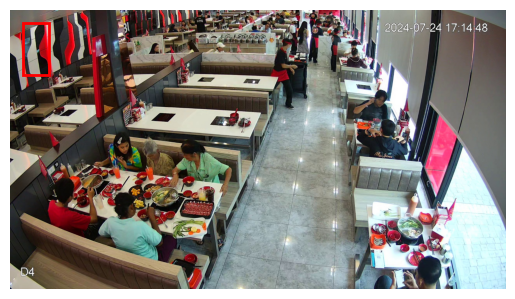

In [57]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
img = plt.imread(r'test/images/20240724171448.jpg')
fig, ax = plt.subplots()
ax.imshow(img)

rect = patches.Rectangle((50, 50), 100, 200, linewidth=2, edgecolor='red', facecolor='none')
ax.add_patch(rect)
ax.axis('off')
plt.show()